# Attention Scoring Functions

Distance functions are  slightly more expensive to compute than inner products. As such, with the softmax operation to ensure nonegative attention weights, much of the work has gone into _attention scoring functions_ alphas that are much easier to compute. 

(__I need to review this concept having into account the previous experiment__).

In [1]:
import math
import torch 
from torch import nn
from d2l import torch as d2l

## Convenience Functions

We need a few functions to make the attention mechanism efficienct to deploy. This includes tools to deal with strings of variable lengths (common for natural language processing) and tools for efficient evaluation on minnibatches (batch matrix multiplication).

### Masked Softmax Operation

One of the most popular applications of the attention mechanism is to sequence models. Hence we need to be able to deal with sequences of different lengths. In some cases, such sequences may end up in the same minibatch, necessitating padding with dummy tokens for shorter sequences. These special tokens do not carry meaning.

__Check out these resources:__
* https://gist.github.com/kaniblu/94f3ede72d1651b087a561cf80b306ca

* https://discuss.pytorch.org/t/apply-mask-softmax/14212

__Study this implementation below:__

In [2]:
def masked_softmax(X, valid_lens):  #@save
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

To illustrate how this function works, consider a minibatch of two examples of size 2 x 4 , where their valid lengths are 2 and 3, respectively. As a result of the masked softmax operation, values beyond the valid lengths for each pair of vectors are all masked as zero.

In [3]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.6681, 0.3319, 0.0000, 0.0000],
         [0.5431, 0.4569, 0.0000, 0.0000]],

        [[0.4453, 0.2049, 0.3498, 0.0000],
         [0.4819, 0.2672, 0.2509, 0.0000]]])

If we need more fine-grained control to specify the valid length for each of the two vectors per example, we simply use a two-dimensional tensor of valid lengths. This yields:

In [4]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3148, 0.2459, 0.4393, 0.0000]],

        [[0.5380, 0.4620, 0.0000, 0.0000],
         [0.1781, 0.3131, 0.1537, 0.3551]]])

### Batch Matrix Multiplication

Another commonly used operation is to multiply batches of matrices with another. This in handy when we have minibatches of queries, keys, and values.

Let's see this in action in a deep learning framework.

In [5]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
d2l.check_shape(torch.bmm(Q, K), (2, 3, 6))

### Scaled Dot-Product Attention

In the following implementation of the scaled dot product attention, we use dropout for model regularization.

In [6]:
class DotProductAttention(nn.Module):  #@save
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [7]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

Let’s check whether the attention weights actually vanish for anything beyond the second and sixth column respectively (due to setting valid length to 2 and 6 ).

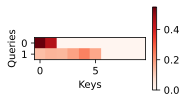

In [8]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## Additive Attention

When queries _q_ and keys _k_ are vectors of different dimensionalities, we can either use a matrix to address teh mismatch, or we can use additive attention as the scoring function. Another benefit is that, as its name indicates, teh attention is additive. This can lead to some minor computational savings. 

An equivalent interpretation of _additive attention_ is that the query and key are concatenated and fed into an MLP with a single hidden layer. Using _tanh_ as the activation functoin and disabling bias terms, we implement additive attention as follows: 

In [9]:
class AdditiveAttention(nn.Module):  #@save
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

Let's see how _AdditiveAttention_ works in our toy example:

In [10]:
queries = torch.normal(0, 1, (2, 1, 20))

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

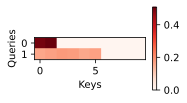

In [11]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In this section we introduced the two key attention scoring functions: dot product and additive attention. They are effective tools for aggregating across sequences of variable length. In particular, the dot product attention is the mainstay of modern Transformer architectures. When queries and keys are vectors of different lengths, we can use the additive attention scoring function instead. Optimizing these layers is one of the key areas of advance in recent years. For instance, Nvidia’s Transformer Library and Megatron (Shoeybi et al., 2019) crucially rely on efficient variants of the attention mechanism.